<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 5: Transfer Learning for Image Classification
</div>


Welcome to this tutorial! Here, we'll explore the process of training a Convolutional Neural Network (CNN) for image classification through the powerful technique of transfer learning. To gain a deeper understanding of transfer learning, consider reviewing the comprehensive [cs231n notes](https://cs231n.github.io/transfer-learning/).

#### The Essence of Transfer Learning

A common challenge in training CNNs is the requirement for a large and diverse dataset. However, not every project or task has the luxury of such a dataset. This is where transfer learning becomes invaluable. In transfer learning, we leverage a pre-trained model— a model trained on a vast dataset, like ImageNet—and adapt it for a different, often more specific task.

#### Key Transfer Learning Scenarios

There are two primary approaches to using a pre-trained model in transfer learning:

1. **Finetuning the ConvNet:**
   - **Process:** Start with a pre-trained model and fine-tune it for a specific task.
   - **Initialization:** We initialize the model with the weights of a pre-trained network, ensuring a strong and relevant foundation.
   - **Training:** The model is then trained further on the new, specific dataset. It adapts and refines the pre-existing knowledge to fit the new data and task at hand.

2. **ConvNet as Fixed Feature Extractor:**
   - **Process:** Use the pre-trained model as a feature extractor and only train a new classifier on top of it.
   - **Frozen Layers:** All the layers of the pre-trained model, except the final fully connected layer, are frozen. Their weights remain unchanged.
   - **New Layer:** The final layer is replaced with a new one, initialized with random weights. This layer is then trained on the new dataset.
   - **Result:** The model harnesses the features learned from the large dataset and combines them with the specific learnings from the new data.

In [ ]:
# # Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy

--2023-11-04 16:01:52--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

normal.npy          100%[===================>]  62.50M   317MB/s    in 0.2s    

2023-11-04 16:01:55 (317 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-11-04 16:01:55--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [ ]:
!pip install Augmentor
!pip install torch torchvision

## A. Data Loading and Preprocessing

Use PyTorch  [`Tensor.repeat()`](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html) to change the number of channels from 1 to 3.


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import Augmentor
import numpy as np
import cv2
import torchvision.transforms as transforms

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

####### augmentation

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

# #創建一個目錄來存儲圖像數據
# output_dir = "image_data"
# os.makedirs(output_dir, exist_ok=True)
# # 將圖像數據保存到目錄中
# for i, image in enumerate(abnormal_scans):
#     image_path = os.path.join(output_dir, f"abnormal_{i}.png")
#     cv2.imwrite(image_path, image)
# for i, image in enumerate(normal_scans):
#     image_path = os.path.join(output_dir, f"normal_{i}.png")
#     cv2.imwrite(image_path, image)
# # 創建 Augmentor.Pipeline() 並指定目錄路徑
# p = Augmentor.Pipeline(output_dir)
# p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
# augmented_images =p.sample(1000)
# augmented_labels = [1] * len(abnormal_scans) + [0] * len(normal_scans)

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float().unsqueeze(1).repeat(1, 3, 1, 1) #repeat(b,c,h,w) -> channel*3
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float().unsqueeze(1).repeat(1, 3, 1, 1)
y_val = torch.from_numpy(y_val).long()

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)


In [ ]:
# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


In [ ]:
# Check images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for images, labels in train_loader:
    print("Size of the image is:", images[0].shape)
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.title(f"{'abnormal' if labels[i] else 'normal'}")
        plt.axis('off')
        plt.imshow(images[i], cmap='gray')
    break

## B. Defining Neural Networks

### 1. Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.

### 2. ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

In [ ]:
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import models

## Method 1
##  https://pytorch.org/vision/stable/models.html

#model = models.resnet18(weights='IMAGENET1K_V1') #512
#model = models.efficientnet_v2_s(weights='IMAGENET1K_V1') #1280
#model = models.densenet121(weights='IMAGENET1K_V1') #1024
model = models.googlenet(weights='IMAGENET1K_V1') #1024


## Method 2: ConvNet as fixed feature extractor (freeze parameters) -> add this two lines

#for param in model.parameters():
#  param.requires_grad = False

#num_ftrs = model.fc.in_features #fc可參考model最後一行" (fc): Linear(in_features=512,...)"

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(1024, 2) #從1000類變2類 -> 改out_feature
model = model.cuda()
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs =30

# Change you model here
# model = ConvGAP()
# print(model)
# model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss() #從BCE變CE
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth') #改由accuracy決定model

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.1481, Train acc: 93.88%, Val loss: 0.0591, Val acc: 97.50%, Best Val loss: 0.0591 Best Val acc: 97.50%
Epoch 2/30, Train loss: 0.0591, Train acc: 98.06%, Val loss: 1.4478, Val acc: 53.50%, Best Val loss: 0.0591 Best Val acc: 97.50%
Epoch 3/30, Train loss: 0.0540, Train acc: 97.88%, Val loss: 1.5979, Val acc: 58.50%, Best Val loss: 0.0591 Best Val acc: 97.50%
Epoch 4/30, Train loss: 0.0384, Train acc: 98.44%, Val loss: 0.1151, Val acc: 95.25%, Best Val loss: 0.0591 Best Val acc: 97.50%
Epoch 5/30, Train loss: 0.0230, Train acc: 99.12%, Val loss: 0.2471, Val acc: 94.75%, Best Val loss: 0.0591 Best Val acc: 97.50%
Epoch 6/30, Train loss: 0.0760, Train acc: 97.81%, Val loss: 0.0784, Val acc: 97.00%, Best Val loss: 0.0591 Best Val acc: 97.50%
Epoch 7/30, Train loss: 0.0278, Train acc: 99.12%, Val loss: 0.2186, Val acc: 91.50%, Best Val loss: 0.0591 Best Val acc: 97.50%
Epoch 8/30, Train loss: 0.0216, Train acc: 99.06%, Val loss: 0.0228, Val acc: 99.00%, Best Val lo

### Visualizing model performance

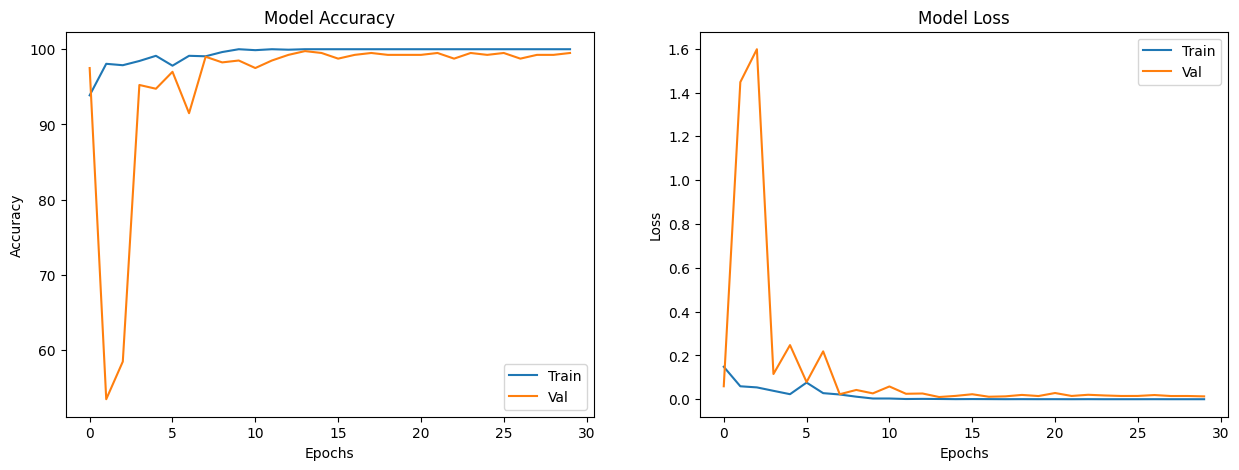

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [ ]:
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

--2023-11-04 16:56:03--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13107328 (12M) [application/octet-stream]
Saving to: ‘test_normal.npy’

test_normal.npy     100%[===================>]  12.50M  --.-KB/s    in 0.08s   

2023-11-04 16:56:04 (153 MB/s) - ‘test_normal.npy’ saved [13107328/13107328]

--2023-11-04 16:56:04--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

### Process Test Dataset

In [ ]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).float().unsqueeze(1).repeat(1, 3, 1, 1) #repeat!
y_test = torch.from_numpy(y_test).long()

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


In [ ]:
# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, 32, shuffle=False)

### Load Trained Model and Evaluate

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        test_correct += (predicted.float() == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 82.75%
